<a href="https://colab.research.google.com/github/zhihui218/Face_Mask_Detection/blob/master/Face_mask_detection_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd gdrive/MyDrive

[Errno 2] No such file or directory: 'gdrive/MyDrive'
/content/gdrive/MyDrive


In [ ]:
# these libraries are used to train the face mask detection model
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
train_path = '/content/gdrive/MyDrive/Face Mask Detection Dataset/dataset/train'
# /content/gdrive/MyDrive/Face Mask Detection Dataset/dataset
valid_path = '/content/gdrive/MyDrive/Face Mask Detection Dataset/dataset/valid'

In [ ]:
# PlotImage() helps to visualize the images with the help of the matplotlib library
# display images horizontally
def PlotImage(img_arr):
  fig,axes = plt.subplots(1,5,figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(img_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

In [ ]:
# perform data augmentation on training data
# data augmentation creates different angles of images
# it’ll zoom the image, increase shear range, horizontal or vertical flip, etc
# to get better accuracy
training_datagen = ImageDataGenerator( rescale=1/255 , rotation_range=40 , width_shift_range=0.2 , height_shift_range=0.2 , shear_range=0.2 , zoom_range=0.2 , horizontal_flip=True , fill_mode='nearest' )

training_data= training_datagen.flow_from_directory(train_path , target_size=(200,200) , batch_size=128 ,class_mode='binary' )

Found 3649 images belonging to 2 classes.


In [ ]:
training_data.class_indices

{'with_mask': 0, 'without_mask': 1}

In [ ]:
# perform data augmentation on validation data
valid_datagen = ImageDataGenerator( rescale=1/255)

valid_data= training_datagen.flow_from_directory(valid_path , target_size=(200,200) , batch_size=128 , class_mode='binary' )

Found 806 images belonging to 2 classes.


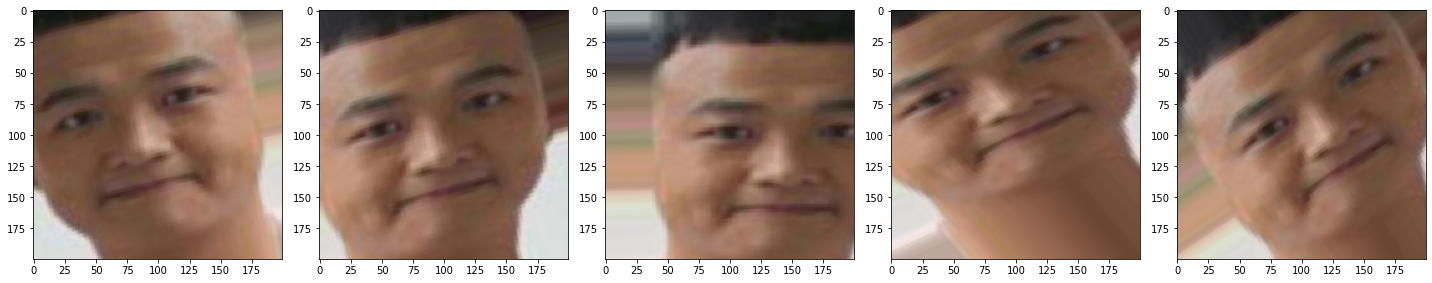

In [ ]:
# take 5 images and pass to PlotImage()
images = [ training_data[0][0][0] for i in range(5) ]
PlotImage(images)

In [ ]:
!nvidia-smi

Thu Dec 15 14:32:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    35W /  70W |  14632MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# define checkpoint
# during model training, if we get a better accuracy than the previous epoch,
# save a new model with better accuracy and continue.
# if no better accuracy, skips and checks for the next epoch and continues.
model_save_path = 'face_mask_detection_model.h5'
checkpoint = ModelCheckpoint(model_save_path , monitor='val_accuracy' ,verbose=1 , save_best_only=True , mode='max')
callbacks_list = [checkpoint]

In [ ]:
model = keras.models.Sequential([
                                    keras.layers.Conv2D(filters=32, kernel_size=3, input_shape=[200, 200, 3]),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),
                                    keras.layers.Conv2D(filters=64, kernel_size=3), 
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),

                                    keras.layers.Conv2D(filters=128, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),
                                    keras.layers.Conv2D(filters=256, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),

                                    keras.layers.Conv2D(filters=512, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),
                                    keras.layers.Conv2D(filters=1024, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),

                                    keras.layers.Dropout(0.5),
                                    # flatten layer to convert multi dimensional images to vector (1-d image or array).
                                    keras.layers.Flatten(), # neural network beulding
                                    keras.layers.Dense(units=128, activation='relu'), # input layers
                                    keras.layers.Dropout(0.1),
                                    keras.layers.Dense(units=256, activation='relu'),                                    
                                    keras.layers.Dropout(0.25),
                                    # output layer with 2 units (Mask or No Mask) and softmax activation function
                                    keras.layers.Dense(units=2, activation='softmax')
])

In [ ]:
model.compile(optimizer= 'adam' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 128)     

In [ ]:
# train the model with training and validation data for 50 epochs
history = model.fit(training_data ,
                    epochs=50,
                    verbose=1, 
                    validation_data= valid_data , callbacks = callbacks_list )

Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 0.9210 - accuracy: 0.5832
Epoch 1: val_accuracy improved from -inf to 0.74566, saving model to face_mask_detection_model.h5
29/29 [==============================] - 67s 2s/step - loss: 0.9210 - accuracy: 0.5832 - val_loss: 0.5658 - val_accuracy: 0.7457
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.3987 - accuracy: 0.8460
Epoch 2: val_accuracy improved from 0.74566 to 0.88958, saving model to face_mask_detection_model.h5
29/29 [==============================] - 58s 2s/step - loss: 0.3987 - accuracy: 0.8460 - val_loss: 0.3284 - val_accuracy: 0.8896
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 0.3171 - accuracy: 0.8907
Epoch 3: val_accuracy did not improve from 0.88958
29/29 [==============================] - 57s 2s/step - loss: 0.3171 - accuracy: 0.8907 - val_loss: 0.3412 - val_accuracy: 0.8772
Epoch 4/50
29/29 [==============================] - ETA: 0s - loss: 0.3049 - accu

In [ ]:
model.save("face_mask_detection_model.h5")